In [2]:
# This noteboook is based on:
# https://www.kaggle.com/byrachonok/pretrained-inceptionresnetv2-base-classifier
# Thank you!

In [3]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from imgaug import augmenters as iaa
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [5]:
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 64

### Load dataset info

In [6]:
path_to_train = '/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/train/'
data = pd.read_csv('/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/train.csv')

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [7]:
from sklearn.model_selection import train_test_split
train_ids, test_ids, train_targets, test_target = train_test_split(
    data['Id'], data['Target'], test_size=0.25, random_state=42)

In [8]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

# reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

for key in label_names.keys():
    data[label_names[key]] = 0
    
train_valid_labels = data.apply(fill_targets, axis=1)
train_valid_labels.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [9]:
train_labels = train_valid_labels.loc[train_ids.index]
df_class_info = []
for label in label_names:
    df_class_info.append(train_labels.loc[train_labels[label_names[label]]==1][['Id', 'Target']])
for label in range(2):
    print(label)
    print(df_class_info[label].shape[0])
    print(df_class_info[label].head())
    print(df_class_info[label].iloc[2])
    print('----------')

0
9645
                                         Id   Target
2703   1683666a-bba9-11e8-b2ba-ac1f6b6435d0  [14, 0]
23141  bed74b60-bbc7-11e8-b2bc-ac1f6b6435d0   [2, 0]
7800   40e53246-bb9d-11e8-b2b9-ac1f6b6435d0   [2, 0]
25802  d4a39d74-bba7-11e8-b2ba-ac1f6b6435d0   [3, 0]
17218  8e92162e-bbc7-11e8-b2bc-ac1f6b6435d0   [3, 0]
Id        40e53246-bb9d-11e8-b2b9-ac1f6b6435d0
Target                                  [2, 0]
Name: 7800, dtype: object
----------
1
944
                                         Id   Target
29539  f353f38c-bbc4-11e8-b2bc-ac1f6b6435d0      [1]
25661  d3661a2a-bba9-11e8-b2ba-ac1f6b6435d0   [1, 0]
3899   20681dc4-bbbd-11e8-b2ba-ac1f6b6435d0  [25, 1]
14651  795b164e-bba3-11e8-b2b9-ac1f6b6435d0      [1]
13574  70906ce0-bba7-11e8-b2ba-ac1f6b6435d0   [6, 1]
Id        20681dc4-bbbd-11e8-b2ba-ac1f6b6435d0
Target                                 [25, 1]
Name: 3899, dtype: object
----------


### Create datagenerator

In [10]:
class data_generator:
    
    def create_train(df_class_info, path_to_train, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            random_indexes = np.random.choice(len(df_class_info), batch_size)
            for i, idx in enumerate(random_indexes):
                df = df_class_info[idx]
                random_index = np.random.randint(df.shape[0])
                image = data_generator.load_image(
                    path_to_train + df.iloc[random_index]['Id'], shape)
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][df.iloc[random_index]['Target']] = 1
            yield batch_images, batch_labels
            
    def create_validation(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
    
    def load_image(path, shape):
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))

        # Modified: image channels.
        # image = np.stack((
        #    R/2 + Y/2, 
        #    G/2 + Y/2, 
        #    B),-1)
        image = np.stack((
        R * 2 / 3 + G / 3,
        B * 2 / 3 + G / 3,
        Y * 2 / 3 + G / 3), -1)
        
        image = cv2.resize(image, (shape[0], shape[1]))
        image = np.divide(image, 255)
        return image  
                
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug


### Show data

In [11]:
# create train datagen
train_datagen = data_generator.create_train(
    df_class_info, path_to_train, 5, (299,299,3), augument=True)

min: 0.0, max: 0.645907603057183


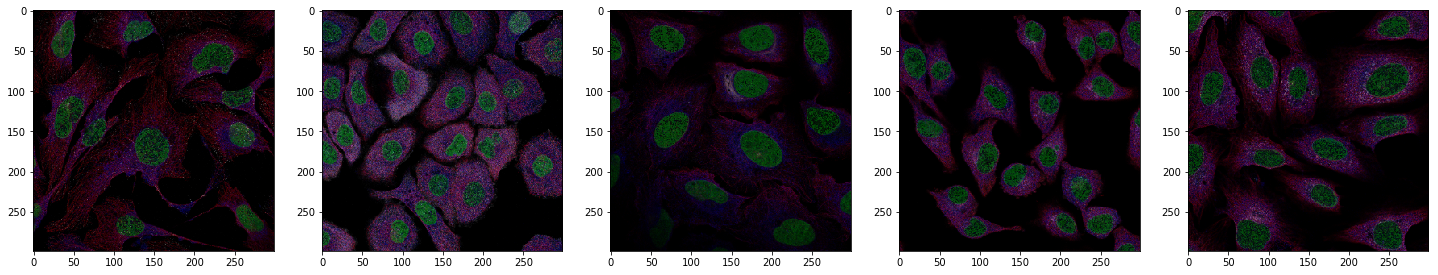

In [12]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

### Create model

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D

from keras.layers.core import Lambda

from keras.models import Model
from keras.applications import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras

threshold = 0.2

def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

Using TensorFlow backend.


In [14]:
def f1_ori(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# Modified. Reference : https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
def avg_pred(y_true, y_pred):
    return K.mean(y_pred, axis=0)

def macro_f1_with_thres(threshold):
    def f1(y_true, y_pred):
            y_true = K.cast(y_true, 'float')
            y_pred = K.cast(K.greater(K.cast(y_pred, 'float'), threshold), 'float')
    
            tp = K.sum(y_true * y_pred, axis=0)
            fp = K.sum((1-y_true)*y_pred, axis=0)
            fn = K.sum(y_true*(1-y_pred), axis=0)

            p = tp / (tp + fp + K.epsilon())
            r = tp / (tp + fn + K.epsilon())

            f1 = 2*p*r / (p+r+K.epsilon())
            f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
            return K.mean(f1)
    return f1

In [21]:
def show_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[3].set_title('avg_pred')
    ax[3].plot(history.epoch, history.history["avg_pred"], label="Train acc")
    ax[3].plot(history.epoch, history.history["val_avg_pred"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

In [16]:
keras.backend.clear_session()

model = create_model(
    input_shape=(299,299,3), 
    n_out=28)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 299, 299, 3)       12        
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 8, 8, 128)         196736    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
__________

### Train model

In [17]:
checkpointer = ModelCheckpoint(
    '/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/InceptionResNetV2.model',
    verbose=2, save_best_only=True)

train_generator = data_generator.create_train(
    df_class_info, path_to_train, BATCH_SIZE, INPUT_SHAPE, augument=False)
# Modified: called different generating functions.
validation_generator = data_generator.create_validation(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = False

# Changed from binary CE to categorical CE.
model.compile(
    loss='categorical_crossentropy',  
    optimizer=Adam(1e-3),
    metrics=['acc', f1_ori, avg_pred])
    # metrics=['acc', macro_f1_with_thres(threshold)])
    
history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    validation_data=next(validation_generator),
    epochs=20, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/20
10/10 [==============================] - 1394s 139s/step - loss: 6.4588 - acc: 0.2375 - f1_ori: 0.1191 - avg_pred: 0.5977 - val_loss: 5.1009 - val_acc: 0.4062 - val_f1_ori: 0.0978 - val_avg_pred: 0.6912

Epoch 00001: val_loss improved from inf to 5.10087, saving model to /Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/InceptionResNetV2.model
Epoch 2/20
10/10 [==============================] - 1347s 135s/step - loss: 6.2489 - acc: 0.2906 - f1_ori: 0.1276 - avg_pred: 0.5767 - val_loss: 4.9234 - val_acc: 0.4062 - val_f1_ori: 0.0975 - val_avg_pred: 0.5552

Epoch 00002: val_loss improved from 5.10087 to 4.92339, saving model to /Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/InceptionResNetV2.model
Epoch 3/20
10/10 [==============================] - 1516s 152s/step - loss: 6.1094 - acc: 0.3453 - f1_ori: 0.1356 - avg_pred: 0.4962 - val_loss: 4.7595 - val_acc: 0.4062 - val_f1_ori: 0.09

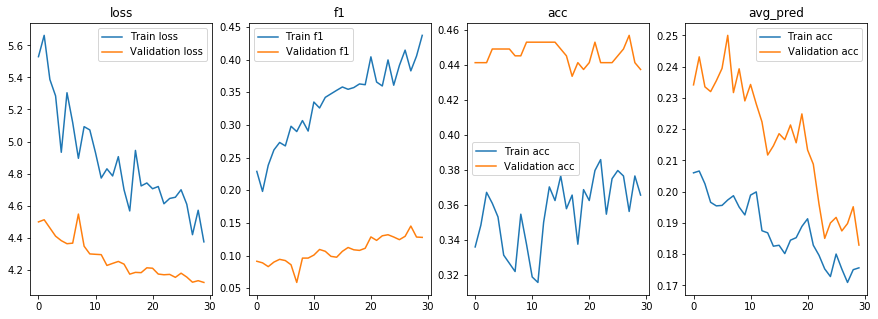

In [22]:
show_history(history)

In [41]:
train_generator = data_generator.create_train(
    df_class_info, path_to_train, 64, INPUT_SHAPE, augument=True)
validation_generator = data_generator.create_validation(
    train_dataset_info[test_ids.index], 256, INPUT_SHAPE, augument=False)

model.layers[2].trainable = True

# Changed from binary CE to Categorical CE
model.compile(
    loss='categorical_crossentropy',  
    optimizer=Adam(1e-4),
    # metrics=['acc', f1_ori, avg_pred])
    metrics = ['acc', macro_f1_with_thres(0.5), avg_pred])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=20,
    validation_data=next(validation_generator),
    epochs=14, 
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/14
20/20 [==============================] - 3420s 171s/step - loss: 3.8847 - acc: 0.4547 - f1: 0.5405 - avg_pred: 0.1171 - val_loss: 3.7655 - val_acc: 0.5273 - val_f1: 0.2192 - val_avg_pred: 0.1196

Epoch 00001: val_loss did not improve from 3.54885
Epoch 2/14
20/20 [==============================] - 3145s 157s/step - loss: 3.7428 - acc: 0.4258 - f1: 0.5577 - avg_pred: 0.1119 - val_loss: 3.7394 - val_acc: 0.4922 - val_f1: 0.2236 - val_avg_pred: 0.1169

Epoch 00002: val_loss did not improve from 3.54885
Epoch 3/14
20/20 [==============================] - 3140s 157s/step - loss: 3.6334 - acc: 0.4867 - f1: 0.5602 - avg_pred: 0.1077 - val_loss: 3.5658 - val_acc: 0.5039 - val_f1: 0.2261 - val_avg_pred: 0.1196

Epoch 00003: val_loss did not improve from 3.54885
Epoch 4/14
20/20 [==============================] - 3137s 157s/step - loss: 3.6242 - acc: 0.4789 - f1: 0.5758 - avg_pred: 0.1064 - val_loss: 3.4529 - val_acc: 0.5195 - val_f1: 0.2369 - val_avg_pred: 0.1287

Epoch 00004: val_lo

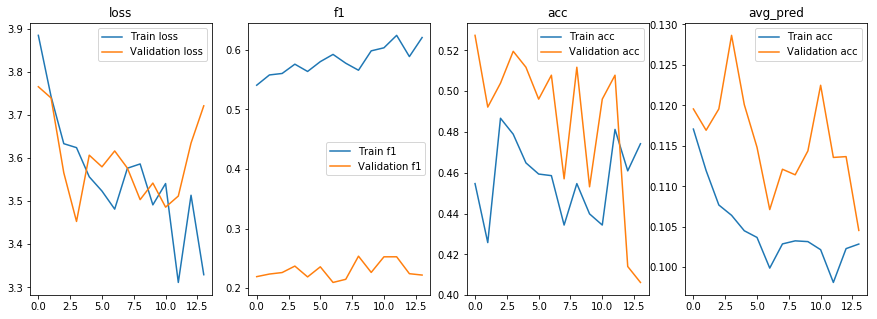

In [42]:
show_history(history)

### Create submit

In [43]:
model = load_model(
    '/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/InceptionResNetV2.model', 
    custom_objects={'f1': macro_f1_with_thres(threshold), 'avg_pred': avg_pred})

In [44]:
submit = pd.read_csv('/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/sample_submission.csv')

In [45]:
%%time
thresholds = [0.3, 0.5, 0.8]
predicted = [[] for _ in range(len(thresholds))]
for name in tqdm(submit['Id']):
    path = os.path.join('/Users/bopang/Documents/ComputerScience/Practice/Kaggle/Human Protein Atlas Image Classification/test/', name)
    image = data_generator.load_image(path, INPUT_SHAPE)
    score_predict = model.predict(image[np.newaxis])[0]
    for idx, th in enumerate(thresholds):
        label_predict = np.arange(28)[score_predict>=th]
        str_predict_label = ' '.join(str(l) for l in label_predict)
        predicted[idx].append(str_predict_label)

100%|██████████| 11702/11702 [2:00:14<00:00,  1.73it/s] 

CPU times: user 5h 42min 5s, sys: 32min 5s, total: 6h 14min 10s
Wall time: 2h 14s


In [46]:
for idx, th in enumerate(thresholds):
    submit['Predicted'] = predicted[idx]
    submit.to_csv('submission_version1_5_{}.csv'.format(th), index=False)

In [ ]:
# Create download link, in case we cannot see the generated file before submitting.
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
# df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))
df = submit

# create a link to download the dataframe
# create_download_link(df)